In [1]:
import matplotlib.pyplot as plt

import numpy as np
from numpy import pi

from scipy.integrate import solve_ivp

# Le pendule

On considère l'éqaution :
$$ \theta^{\prime\prime} = -\sin{\theta}$$

Pour résoudre cette équation, on définie le tableau $y(t) = (\theta(t), \theta^\prime(t)$. 

* Ecrire la fonction Python ``f(t, y)`` qui renvoie la dérivée de $y$

* Résoudre et tracer le resultat de l'équation différentielle pour les conditions initiales : $\theta(0) = 2\pi/4$ et $\theta^\prime(0) = 0$

* Vérifier de l'énergie totale est conservée

In [2]:
def f(t, y):
    theta, theta_prime = y
    return np.array([theta_prime, -np.sin(theta)])


Text(0,0.5,'$\\theta$')

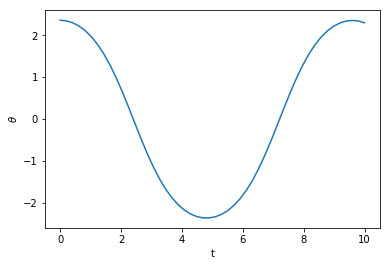

In [3]:
t_eval = np.linspace(0, 10)

res = solve_ivp(f, [0, 10], [3*np.pi/4, 0], t_eval=t_eval)


plt.plot(res.t, res.y[0])
plt.xlabel('t')
plt.ylabel(r'$\theta$')

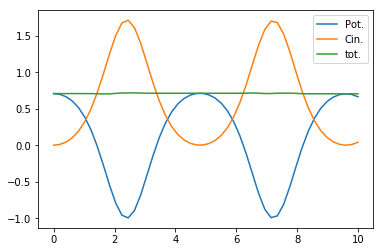

In [4]:
energie_potentielle = -np.cos(res.y[0])
energie_cinetique = res.y[1]**2/2

plt.plot(res.t, energie_potentielle, label='Pot.')
plt.plot(res.t, energie_cinetique, label='Cin.')
plt.plot(res.t,  energie_potentielle + energie_cinetique, label='tot.')
plt.legend()

# Nuage d'ions

On considère un nuage de $N$ ions de masse $m$ et charge $q$. On note $\vec{r_i}$ et $\vec{v_i}$ la position et la vitesse du ième ion. Les ions sont dans un piège électrostatique. De plus, ils interagissent entre eux par la force de Coulomb. 

La force électrostatique dérive d'un potentiel électrostatique :

$$V(\vec{r}) = \frac12 k_x r_x^2 +\frac12 k_y r_y^2 + \frac12 k_z r_z^2$$

La force de Coulomb s'écrira sous la forme:

$$\vec{f_i}(\vec{r_i}, \vec{r_j}) = \kappa \frac{q^2}{|\vec{r_i} - \vec{r_j}|^3}(\vec{r_i} - \vec{r_j})$$

Pour simplifier et avoir une meilleure représentation graphique, on suprimera totalement la dimension $z$. 

On utilisera des unités adimensionnées avec des constantes de l'ordre de 1. Par défaut on prendra : $m=9$, $q=1$, $k_x=1$, $k_y=1.3$, $\kappa=1$.

On va considérer la dynamique de 4 tableaux numpy : ``r_x``, ``r_y``, ``v_x``, ``v_y``. Toutes les fonctions seront écrites avec ces variables. On ne regroupera les 4 tableaux que dans la fonction qui sera utilisé par ``solve_ivp``.

Les paramètres seront des constantes globales.

* Ecrire la fonction ``force_piege(r_x, r_y)`` qui renvoie la force dérivant du potentiel (``f_x`` et ``f_y``).

* Ecrire la fonction ``force_coulomb(r_x, r_y)`` qui renvoie $f_x$ et $f_y$, le force de Coulomb

Le tableau ``y`` est défini en rassemblant les 4 tableau numpy. On défini les fonctions suivantes :

    def join(r_x, r_t, v_x, v_y):
        return np.concatenate((r_x, r_y, v_x, v_y))

    def split(y):
        N = len(y)//4
        return y[:N], y[N:2*N], y[2*N:3*N], y[3*N:4*N]
        
* Ecrire la fonction ``f(t, y)`` qui défini la dynamique du problème.

* On condidère un nuage avec une distribution initiale donnée par une loi de Maxwell-Boltzmann (avec $k_B=1$ et $T=1$) pour les particules sans interaction. Calculer jusqu'au temps $T=20$ l'évolution de la position des particules.

* Vérifier que l'énergie totale est conservée. On utilisera les fonctions ci-dessous.

* Faire une animation

* On rajoute une force de dissipation, selon l'axe $x$ : 

   $$ \vec F_{i,x} = -\alpha v_{_, x} $$
  
  Simuler l'experience en prenant $\alpha = 0.1$ et $N=20$. Que se passe-t-il au temps long ?

In [5]:
m =9
q = 1
k_x = 1
k_y = 1.3

kappa=1

k_B = 1
T = 1

In [6]:
def force_piege(r_x, r_y):
    return -k_x*r_x, -k_y*r_y

def energie_piege(r_x, r_y):
    return np.sum(k_x*r_x**2/2 + k_y*r_y**2/2)

def force_coulomb(r_x, r_y):
    N = len(r_x)
    f_x = np.zeros(N)
    f_y = np.zeros(N)
    for i in range(N):
        tot_x, tot_y = 0, 0
        for j in range(N):
            if i!=j:
                d2 = (r_x[i]-r_x[j])**2 + (r_y[i]-r_y[j])**2
                coef = kappa*q**2/(np.sqrt(d2)**3)
                tot_x += coef*(r_x[i]-r_x[j])
                tot_y += coef*(r_y[i]-r_y[j])
        f_x[i] = tot_x
        f_y[i] = tot_y
    return f_x, f_y

def energie_coulomb(r_x, r_y):
    N = len(r_x)
    total = 0
    for i in range(N-1):
        for j in range(i+1, N):
            d2 = (r_x[i]-r_x[j])**2 + (r_y[i]-r_y[j])**2
            total += kappa*q**2/np.sqrt(d2)
    return total

In [7]:
# Fonction pour passer de 4 tableau à un seul et réciproquement
def join(r_x, r_y, v_x, v_y):
    return np.concatenate((r_x, r_y, v_x, v_y))

def split(y):
    N = len(y)//4
    return y[:N], y[N:2*N], y[2*N:3*N], y[3*N:4*N]

In [8]:
# Calcul de l'énergie
def energie_cinetique(r_x, r_y, v_x, v_y):
    return np.sum(.5*m*v_x**2 + .5*m*v_y**2)
    
def energie_totale(r_x, r_y, v_x, v_y):
    energie_cinetique = np.sum(.5*m*v_x**2 + .5*m*v_y**2)
    return (energie_coulomb(r_x, r_y) +
            energie_piege(r_x, r_y) +
            energie_cinetique)

In [9]:
def force_totale(r_x, r_y, v_x, v_y):
    piege = force_piege(r_x, r_y)
    coulomb = force_coulomb(r_x, r_y)
    return piege[0]+coulomb[0], piege[1]+coulomb[1]



def f(t, y):
    r_x, r_y, v_x, v_y = split(y)
    f_x, f_y = force_totale(r_x, r_y, v_x, v_y)
    return join(v_x, v_y, f_x/m, f_y/m)

In [10]:
N = 50

r_x_0 = np.random.normal(size=N)
r_y_0 = np.random.normal(size=N)
v_x_0 = np.random.normal(scale=1/np.sqrt(m), size=N)
v_y_0 = np.random.normal(scale=1/np.sqrt(m), size=N)

t_max = 20
res = solve_ivp(f, [0, t_max], join(r_x_0, r_y_0, v_x_0, v_y_0), 
               t_eval=np.linspace(0, t_max))


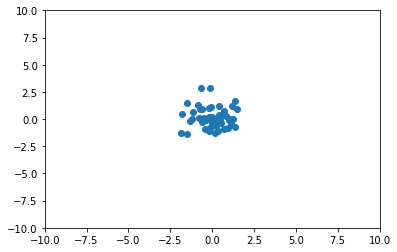

In [11]:
# Pour afficher une animation
# res est le tableau provenant de solve_ivp

from IPython.display import HTML
import matplotlib.animation

fig, ax = plt.subplots()
l, = ax.plot(split(res.y[:,0])[0], split(res.y[:,0])[1], 'o')
ax.set_xlim(-10, 10)
ax.set_ylim(-10, 10)

def animate(i):
    r_x, r_y, v_x, v_y = split(res.y[:,i])
    l.set_data(r_x, r_y)

ani = matplotlib.animation.FuncAnimation(fig, 
                                         animate, 
                                         frames=len(res.t))


HTML(ani.to_jshtml())

In [12]:
alpha = 0.1
def force_friction(r_x, r_y, v_x, v_y):
    return -alpha*v_x, 0*v_y

def force_totale(r_x, r_y, v_x, v_y):
    piege = force_piege(r_x, r_y)
    coulomb = force_coulomb(r_x, r_y)
    friction = force_friction(r_x, r_y, v_x, v_y)
    return piege[0]+coulomb[0]+friction[0], piege[1]+coulomb[1]+friction[0]



def f(t, y):
    r_x, r_y, v_x, v_y = split(y)
    f_x, f_y = force_totale(r_x, r_y, v_x, v_y)
    return join(v_x, v_y, f_x/m, f_y/m)

In [13]:
N = 20

r_x_0 = np.random.normal(size=N)
r_y_0 = np.random.normal(size=N)
v_x_0 = np.random.normal(scale=1/np.sqrt(m), size=N)
v_y_0 = np.random.normal(scale=1/np.sqrt(m), size=N)

t_max = 1500
t_eval=np.linspace(0, t_max, 400)
res = solve_ivp(f, [0, t_max], join(r_x_0, r_y_0, v_x_0, v_y_0), 
               t_eval=t_eval)


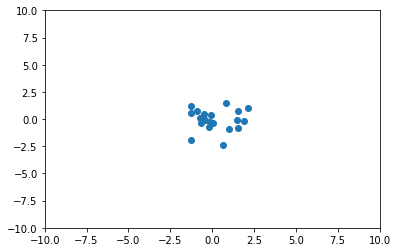

In [14]:
fig, ax = plt.subplots()
l, = ax.plot(split(res.y[:,0])[0], split(res.y[:,0])[1], 'o')
ax.set_xlim(-10, 10)
ax.set_ylim(-10, 10)

def animate(i):
    r_x, r_y, v_x, v_y = split(res.y[:,i])
    l.set_data(r_x, r_y)

ani = matplotlib.animation.FuncAnimation(fig, 
                                         animate, 
                                         frames=len(res.t),
                                        interval=100)


HTML(ani.to_jshtml())